# Distributed Matrix Multiplication – Benchmark Analysis

This notebook analyzes benchmark results for **block-based MapReduce matrix multiplication** implemented in **Python and Java**. The results were obtained using a PC equipped with a 6-core CPU and 16GB DDR4 RAM at 3200mhz.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Load benchmark data

In [2]:
df = pd.read_csv('benchmarks/results.csv')
df

,language,matrix_size,block_size,workers,generation,blocking,map,map_shuffle,reduce,total
0,java,256,16,12,0.004468,0.003590,0.012617,0.006394,0.035498,0.060472
1,java,256,32,12,0.003684,0.001169,0.002223,0.000382,0.011941,0.015788
2,java,256,64,12,0.001349,0.000435,0.001478,0.000075,0.008858,0.010894
3,java,512,16,12,0.004929,0.009136,0.020106,0.012976,0.124860,0.167189
4,java,512,32,12,0.006046,0.002563,0.002008,0.000724,0.091965,0.097318
5,java,512,64,12,0.006218,0.002377,0.004042,0.000096,0.073648,0.080268
6,java,1024,16,12,0.019866,0.007478,0.015671,0.030432,1.247026,1.300686
7,java,1024,32,12,0.018419,0.005241,0.002953,0.002943,0.666053,0.677256
8,java,1024,64,12,0.023860,0.004145,0.001366,0.000336,0.564911,0.570978
9,python,256,16,12,0.007271,0.003043,0.231631,0.001078,1.599146,1.842168


## Total execution time vs matrix size

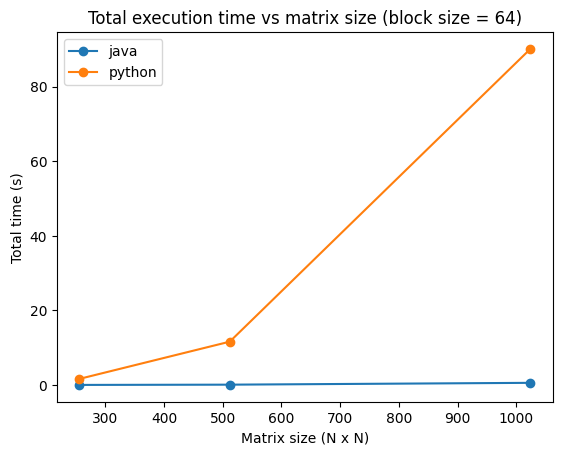

In [3]:
for lang in df['language'].unique():
    subset = df[(df['language'] == lang) & (df['block_size'] == 64)]
    plt.plot(subset['matrix_size'], subset['total'], marker='o', label=lang)

plt.xlabel('Matrix size (N x N)')
plt.ylabel('Total time (s)')
plt.title('Total execution time vs matrix size (block size = 64)')
plt.legend()
plt.show()

## Effect of block size (fixed matrix size)

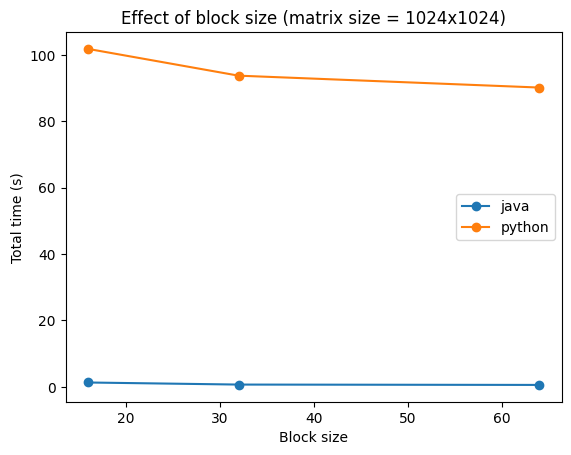

In [4]:
N = df['matrix_size'].max()

for lang in df['language'].unique():
    subset = df[(df['language'] == lang) & (df['matrix_size'] == N)]
    plt.plot(subset['block_size'], subset['total'], marker='o', label=lang)

plt.xlabel('Block size')
plt.ylabel('Total time (s)')
plt.title(f'Effect of block size (matrix size = {N}x{N})')
plt.legend()
plt.show()

## Phase breakdown (Map vs Reduce)

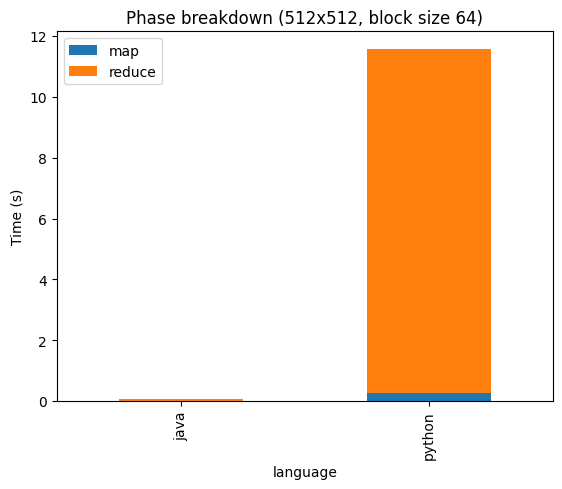

In [11]:
subset = df[(df['matrix_size'] == 512) & (df['block_size'] == 64)]

subset.set_index('language')[['map', 'reduce']].plot(
    kind='bar', stacked=True
)

plt.ylabel('Time (s)')
plt.title('Phase breakdown (512x512, block size 64)')
plt.show()

## Speedup: Java vs Python

In [6]:
pivot = df.pivot_table(
    index=['matrix_size', 'block_size'],
    columns='language',
    values='total'
)

pivot['speedup_java_vs_python'] = pivot['python'] / pivot['java']
pivot

language                    java      python  speedup_java_vs_python
matrix_size block_size                                              
256         16          0.060472    1.842168               30.463157
            32          0.015788    1.763284              111.685077
            64          0.010894    1.633792              149.971728
512         16          0.167189   13.171401               78.781505
            32          0.097318   12.134810              124.692349
            64          0.080268   11.614642              144.698286
1024        16          1.300686  101.769090               78.242627
            32          0.677256   93.716930              138.377408
            64          0.570978   90.137581              157.865243

## Conclusions

- Java consistently outperforms Python for large matrices due to faster block computation.
- Shuffle cost dominates for small block sizes.
- Larger block sizes reduce communication but increase reducer workload.
- Block-based MapReduce scales significantly better than element-wise approaches.
